In [1]:
import astropy.io.fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import factorial
import scipy.interpolate
import numexpr as ne
import os.path

In [2]:
filename = "ERS_NGTS10_2022_nodrift_seg_038.fits"
hdul = astropy.io.fits.open(filename)
data = hdul[1].data
N_int, N_grp, N_row, N_col = data.shape
gain = hdul[0].header["GAINCF"]
R = gain * hdul[0].header["RDNOISE"]

#print(data.shape)

#Assumptions for dark current subtraction
assert(hdul[0].header["NFRAMES"] == 1)
assert(hdul[0].header["GROUPGAP"] == 0)

In [3]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
                                                                                
        MIRI Simulation Metadata                                                
                                                                                
DATE    = '2022-01-30T14:59:33.967' / UTC date file created                     
ORIGIN  = 'MIRI European Consortium' / Organization responsible for creating fil
FILETYPE= 'Ramp (level 1b)'    / Type of data in the file                       
DATAMODL= 'RampModel'          / Type of data model                             
CREATOR = 'MIRI SCA simulator (MiriTE 7.8)' / Software which created the data   
TELESCOP= 'JWST    '        

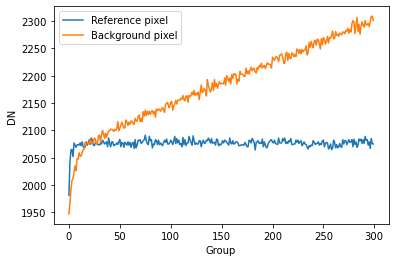

In [4]:
plt.plot(data[0,:,100,0], label="Reference pixel")
plt.plot(data[0,:,100,17], label="Background pixel")
plt.legend()
plt.xlabel("Group")
plt.ylabel("DN")
plt.savefig("ref_vs_bkd.png")

(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)
(416, 72) (44, 300, 416, 72)


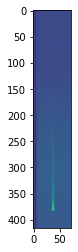

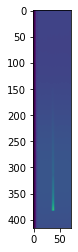

In [5]:
def apply_nonlinearity(data, filename="jwst_miri_linearity_0024.fits", slitless_left=0, slitless_right=72, slitless_top=528, slitless_bot=944):
    data_float = np.array(data, dtype=float)
    with astropy.io.fits.open(filename) as hdul:
        coeffs = np.copy(hdul[1].data[:, slitless_top:slitless_bot, slitless_left:slitless_right])
        result = np.zeros(data.shape)
        exp_data = np.ones(data.shape)
        
        for i in range(len(coeffs)):
            print(coeffs[i].shape, data.shape)            
            result += coeffs[i] * exp_data #data_float**i
            exp_data *= data_float
    return result


after_nonlinear = apply_nonlinearity(data)

plt.imshow(data[0,-1], vmin=0, vmax=1e4)
plt.figure()
plt.imshow(after_nonlinear[0,-1], vmin=0, vmax=1e4)

In [ ]:
#Reset Switch Charge Decay (RSCD) Correction?  No idea how to do

(2, 1000, 416, 72)


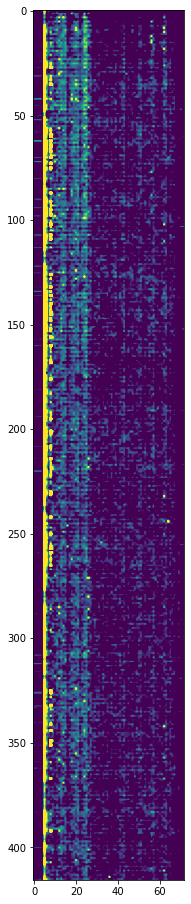

In [7]:
#Dark current subtraction
def subtract_dark(data, filename="jwst_miri_dark_0048.fits"):    
    with astropy.io.fits.open(filename) as dark_hdul:
        dark = dark_hdul[1].data
    print(dark.shape)
    N_int_dark = dark.shape[0]
    N_grp_dark = dark.shape[1]
    
    assert(N_int > N_int_dark)
    assert(N_grp <= N_grp_dark)
    
    result = np.copy(data)
    result[:N_int_dark] -= dark[:, :N_grp]
    result[N_int_dark:] -= dark[-1, :N_grp]
    return result
    
after_dark = subtract_dark(after_nonlinear)

plt.figure(figsize=(16,16))
plt.imshow((after_nonlinear - after_dark)[0,-1], vmin=0, vmax=20)

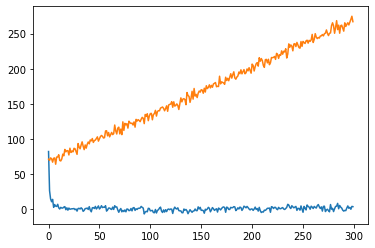

In [8]:
plt.plot(after_dark[0,:,100,1])
plt.plot(after_dark[0,:,100,17] - 1750)

In [9]:
after_gain = after_dark * gain

In [10]:
# N = N_grp - 1
# j = np.arange(1, N + 1)

# signal_estimate = (after_gain[:, -1] - after_gain[:, 0]) / (after_gain.shape[1] - 1)
# ratio_estimate = (after_gain[:, -1] - after_gain[:, 0])  / R**2
# ratio_estimate[ratio_estimate <= 1e-6] = 1e-6

# ramp_signal_estimate = np.zeros(signal_estimate.shape)
# ramp_error = np.zeros(signal_estimate.shape)
# diff_array = np.diff(after_gain, axis=1)
# noise = np.sqrt(2*R**2 + signal_estimate)
# old_bad = np.zeros(diff_array.shape, dtype=bool)

# for i in range(len(after_gain)):
#     l = np.arccosh(1 + ratio_estimate[i]/N/2)[:, :, np.newaxis]
#     weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
    
#     #Find cosmic rays and other anomalies
#     z_scores = (diff_array[i] - signal_estimate[i, np.newaxis]) / noise[i, np.newaxis]
#     bad = np.abs(z_scores) > 5
#     old_bad[i] = bad
#     weights[bad.transpose(1,2,0)] = 0
    
#     ramp_signal_estimate[i] = np.sum(diff_array[i].transpose(1,2,0) * weights, axis=2) / np.sum(weights, axis=2)
#     ramp_error[i] = 1. / np.sqrt(np.sum(weights, axis=2))
#     print(i)
   

In [11]:
#np.sum((ramp_signal_estimate + 2*R**2) < 0)
#plt.imshow(np.sum(ramp_signal_estimate, axis=0))

In [12]:
#Ignore first bad_grps groups, and leftmost left_margin pixels
bad_grps = 5
left_margin = 10

N = N_grp - 1 - bad_grps
j = np.array(np.arange(1, N + 1), dtype=float)

#full_signal = 
ramp_signal_estimate = (after_gain[:,-1,:,left_margin:] - after_gain[:, bad_grps,:,left_margin:]) / N
ramp_error = np.zeros(ramp_signal_estimate.shape)
diff_array = np.diff(after_gain[:,bad_grps:,:,left_margin:], axis=1)
noise = np.sqrt(2*R**2 + ramp_signal_estimate)
bad_mask = np.zeros(diff_array.shape, dtype=bool)

for iteration in range(100):
    old_bad_mask = np.copy(bad_mask)
    for i in range(len(after_gain)):
        ratio_estimate = ramp_signal_estimate[i] / R**2
        ratio_estimate[ratio_estimate < 1e-6] = 1e-6
        l = np.arccosh(1 + ratio_estimate/2)[:, :, np.newaxis]

        #test_weights = -R**-2 * np.exp(l) * (1 - np.exp(-j*l)) * (np.exp(j*l - l*N) - np.exp(l)) / (np.exp(l) - 1)**2 / (np.exp(l) + np.exp(-l*N))
        
        weights = ne.evaluate("-R**-2 * exp(l) * (1 - exp(-j*l)) * (exp(j*l - l*N) - exp(l)) / (exp(l) - 1)**2 / (exp(l) + exp(-l*N))")
        #print(weights.shape)
        #print(np.allclose(weights, test_weights))
        #Find cosmic rays and other anomalies
        z_scores = (diff_array[i] - ramp_signal_estimate[i, np.newaxis]) / noise[i, np.newaxis]
        bad_mask[i] = np.abs(z_scores) > 5
        weights[bad_mask[i].transpose(1,2,0)] = 0

        ramp_signal_estimate[i] = np.sum(diff_array[i].transpose(1,2,0) * weights, axis=2) / np.sum(weights, axis=2)
        ramp_error[i] = 1. / np.sqrt(np.sum(weights, axis=2))
        #print(ramp_signal_estimate[i,367,28], ramp_error[i,367,28])
        #print(i)
        #print(i, np.sum()
    num_changed = np.sum(old_bad_mask != bad_mask)
    if num_changed == 0:
        break
    print("Num changed", iteration, num_changed)
    
full_signal = (after_gain[:,-1] - after_gain[:,bad_grps]) / N
full_signal[:, bad_grps:, :, left_margin:] = ramp_signal_estimate
full_noise = np.sqrt(2*R**2 + full_signal)
full_noise[:, bad_grps:, :, left_margin:] = ramp_error

75.20836229917612 0.5090390073554977
75.23562189371867 0.5088635155414577
75.09834923062029 0.5082027974070066
75.17563489885508 0.50885911031895
75.19668310386677 0.5091633158524163
75.13407044820147 0.5086543902708484
75.06933632973897 0.5083719182339556
75.13181583684405 0.5084809661877677
75.21206881863475 0.5093321079207935
75.20894240597745 0.508821154295678
75.18691785347302 0.5090544263258351
75.1537848999314 0.5089389034259733
75.1659701199716 0.5086609922346012
75.14468462365154 0.5087099849329807
75.1168997541468 0.5084407427680603
75.24745606397288 0.5096162392995911
75.25434051458984 0.5091721273845686
75.25775778476253 0.5097892893421541
75.13283401080054 0.5084319450329345
75.21144353774503 0.5092254615433558
75.11418281932652 0.5084875663351813
75.22210620898953 0.5090500213658163
75.1735707081244 0.50877437772436
75.15766716643928 0.5082584445027727
75.17713596588321 0.5087611699968762
75.14671267493922 0.5084319450329345
75.22138485958362 0.5093365154477049
75.2516996

KeyboardInterrupt: 

In [23]:
print(ramp_signal_estimate.shape, ramp_error.shape)
print(ramp_signal_estimate[0,367,28], ramp_error[0,367,28])

(44, 416, 62) (44, 416, 62)
75.13901429243242 0.034322286127270625


In [ ]:
old_bad_mask.shape

In [ ]:
%matplotlib qt
plt.imshow(signal_estimate[0], vmin=0, vmax=1e2)
plt.figure()
plt.imshow(ramp_signal_estimate[0], vmin=0, vmax=1e2)

In [ ]:
%matplotlib inline

In [ ]:
plt.plot(after_gain[0,:,379,28])
plt.figure()
plt.plot(bad_mask[0,:,379,28])

In [ ]:
xs = np.arange(N_grp)
print(np.polyfit(xs, after_gain[0,:,379,28], 1))
print(np.polyfit(xs[5:250], after_gain[0,:,379,28][5:250], 1))

In [ ]:
ramp_error[0,379,28]

In [ ]:
plt.plot(np.diff(after_gain[0,:,379,28]), '.')
plt.figure()
plt.hist(np.diff(after_gain[0,:,379,28]))

In [ ]:
ramp_signal_estimate[0,379,28]

In [ ]:
plt.plot(np.diff(data[0,:,379,28]), '.')
plt.figure()
plt.hist(np.diff(data[0,:,379,28]))

In [ ]:
%matplotlib qt
plt.imshow(combined, vmin=0, vmax=1e3)
plt.figure()

xs = np.arange(combined.shape[1])
profile = np.sum(combined, axis=0)
trace_loc = np.argmax(profile)
print(trace_loc)
plt.plot(profile)
plt.axvline(trace_loc)
plt.axvline(trace_loc - 8)
plt.axvline(trace_loc + 8)
plt.axvline(10)

left_xmin = 10#:trace_loc-8
left_xmax = trace_loc - 8
right_xmin = trace_loc + 8
right_xmax = combined.shape[1]

background_pixels = np.hstack([combined[:, left_xmin:left_xmax], combined[:, right_xmin:right_xmax]])
bkd_xs = np.append(xs[left_xmin:left_xmax], xs[right_xmin:right_xmax])
print(len(bkd_xs), background_pixels.shape)

bkd_sub = np.zeros(combined.shape)
for i in range(len(background_pixels)):
    coeffs = np.polyfit(bkd_xs, background_pixels[i], 1)
    predicted = np.polyval(coeffs, bkd_xs)
    if i % 10 == 0:
        plt.plot(bkd_xs, background_pixels[i])
        plt.plot(bkd_xs, predicted)
    bkd_sub[i] = combined[i] - np.polyval(coeffs, xs) #predicted

background = np.median(background_pixels, axis=1)

#print(background.shape)
plt.figure()
plt.plot(background)

#bkd_sub = combined - background[:,np.newaxis]
plt.figure()
plt.imshow(bkd_sub, vmin=0, vmax=20)

In [ ]:
plt.imshow(combined)

In [ ]:
%matplotlib inline
plt.plot(background_pixels[100])

In [ ]:
hdul[0].header

In [1]:
def apply_flat(signal, error, filename="jwst_miri_flat_0745.fits"):
    with astropy.io.fits.open(filename) as hdul:
        flat = hdul[1].data
    #print(flat.shape)
    print(ramp_signal_estimate.shape)
    invalid = np.isnan(flat)
    flat[invalid] = 1
    final_signal = signal / flat
    final_error = error / flat
    final_error[:,invalid] = np.inf
    return final_signal, final_error
    
final_signal, final_error = apply_flat(ramp_signal_estimate, ramp_error)

NameError: name 'ramp_signal_estimate' is not defined

In [ ]:
sci_hdu = astropy.io.fits.ImageHDU(final_signal, name="SCI")
err_hdu = astropy.io.fits.ImageHDU(final_error, name="ERR")
output_hdul = astropy.io.fits.HDUList([hdul[0], sci_hdu, err_hdu])
output_hdul.writeto("rateints_" + os.path.basename(filename), overwrite=True)

In [ ]:
%matplotlib qt
plt.imshow(final_signal[0], vmin=0, vmax=1e2)


In [ ]:
hdul[0].header

In [ ]:
hdul = astropy.io.fits.open("jwst_miri_rscd_0010.fits")
#plt.imshow(hdul[0].data)
print(hdul[1].data[("SLITLESSPRISM", "FAST", 4)])

In [ ]:
hdul[3].data

In [9]:
flat = astropy.io.fits.open("jwst_miri_flat_0745.fits")
flat[2].header
%matplotlib qt
plt.imshow(flat[2].data / flat[1].data)